# 3D Multi-organ Segmentation with UNETR  (BTCV Challenge)

Original prepared by: **Ali Hatamizadeh** and **Yucheng Tang**. (https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb, Apache 2 licence)

EDIT: Modification to test UNET version **Benjamin Irving**

This tutorial demonstrates how to construct a training workflow of UNETR [1] on multi-organ segmentation task using the BTCV challenge dataset.
![image](https://lh3.googleusercontent.com/pw/AM-JKLU2eTW17rYtCmiZP3WWC-U1HCPOHwLe6pxOfJXwv2W-00aHfsNy7jeGV1dwUq0PXFOtkqasQ2Vyhcu6xkKsPzy3wx7O6yGOTJ7ZzA01S6LSh8szbjNLfpbuGgMe6ClpiS61KGvqu71xXFnNcyvJNFjN=w1448-h496-no?authuser=0)

And it contains the following features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNETR model, DiceCE loss function, Mean Dice metric for multi-organ segmentation task.

The dataset comes from https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

Under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm. 

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kideny 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from: 


1. [UNETR: Transformers for 3D Medical Image Segmentation](https://arxiv.org/abs/2103.10504)

2. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

3. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](https://lh3.googleusercontent.com/pw/AM-JKLX0svvlMdcrchGAgiWWNkg40lgXYjSHsAAuRc5Frakmz2pWzSzf87JQCRgYpqFR0qAjJWPzMQLc_mmvzNjfF9QWl_1OHZ8j4c9qrbR6zQaDJWaCLArRFh0uPvk97qAa11HtYbD6HpJ-wwTCUsaPcYvM=w1724-h522-no?authuser=0)



The image patches show anatomies of a subject, including: 
1. large organs: spleen, liver, stomach. 
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas. 
3. Vascular tissues: aorta, IVC, P&S Veins. 
4. Glands: left and right adrenal gland

If you find this tutorial helpful, please consider citing [1]:

[1]: Hatamizadeh, A., Tang, Y., Nath, V., Yang, D., Myronenko, A., Landman, B., Roth, H.R. and Xu, D., 2022. Unetr: Transformers for 3d medical image segmentation. In Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision (pp. 574-584).

## Setup environment

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     |████████████████████████████████| 924 kB 14.9 MB/s 


In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, BasicUNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.9.dev2223
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0428f5a29f1fdc577f2c558490266d9db00583e3
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  90607      0 --:--:-- --:--:-- --:--:-- 90607
OK
65 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 65 not upgraded.
Need to get 11.6 MB of archives.
After this operation, 27.4 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.2_amd64.deb ...
Unpacking gcsfuse (0.41.2) ...
Setting up gcsfuse (0.41.2) ...


In [ ]:
!mkdir gcp-data
!gcsfuse --implicit-dirs  public-datasets-bji  gcp-data

2022/06/07 17:19:01.317602 Start gcsfuse/0.41.2 (Go version go1.17.6) for app "" using mount point: /content/gcp-data
2022/06/07 17:19:01.331416 Opening GCS connection...
2022/06/07 17:19:01.738658 Mounting file system "public-datasets-bji"...
2022/06/07 17:19:01.769171 File system has been successfully mounted.


In [ ]:
os.environ["MONAI_DATA_DIRECTORY"] = "/content/gcp-data/btcv/Abdomen/RawData/Colab"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
model_name = "unet_btcv_segmentation"

/content/gcp-data/btcv/Abdomen/RawData/Colab


## Setup transforms for training and validation

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

Abdomen dataset?

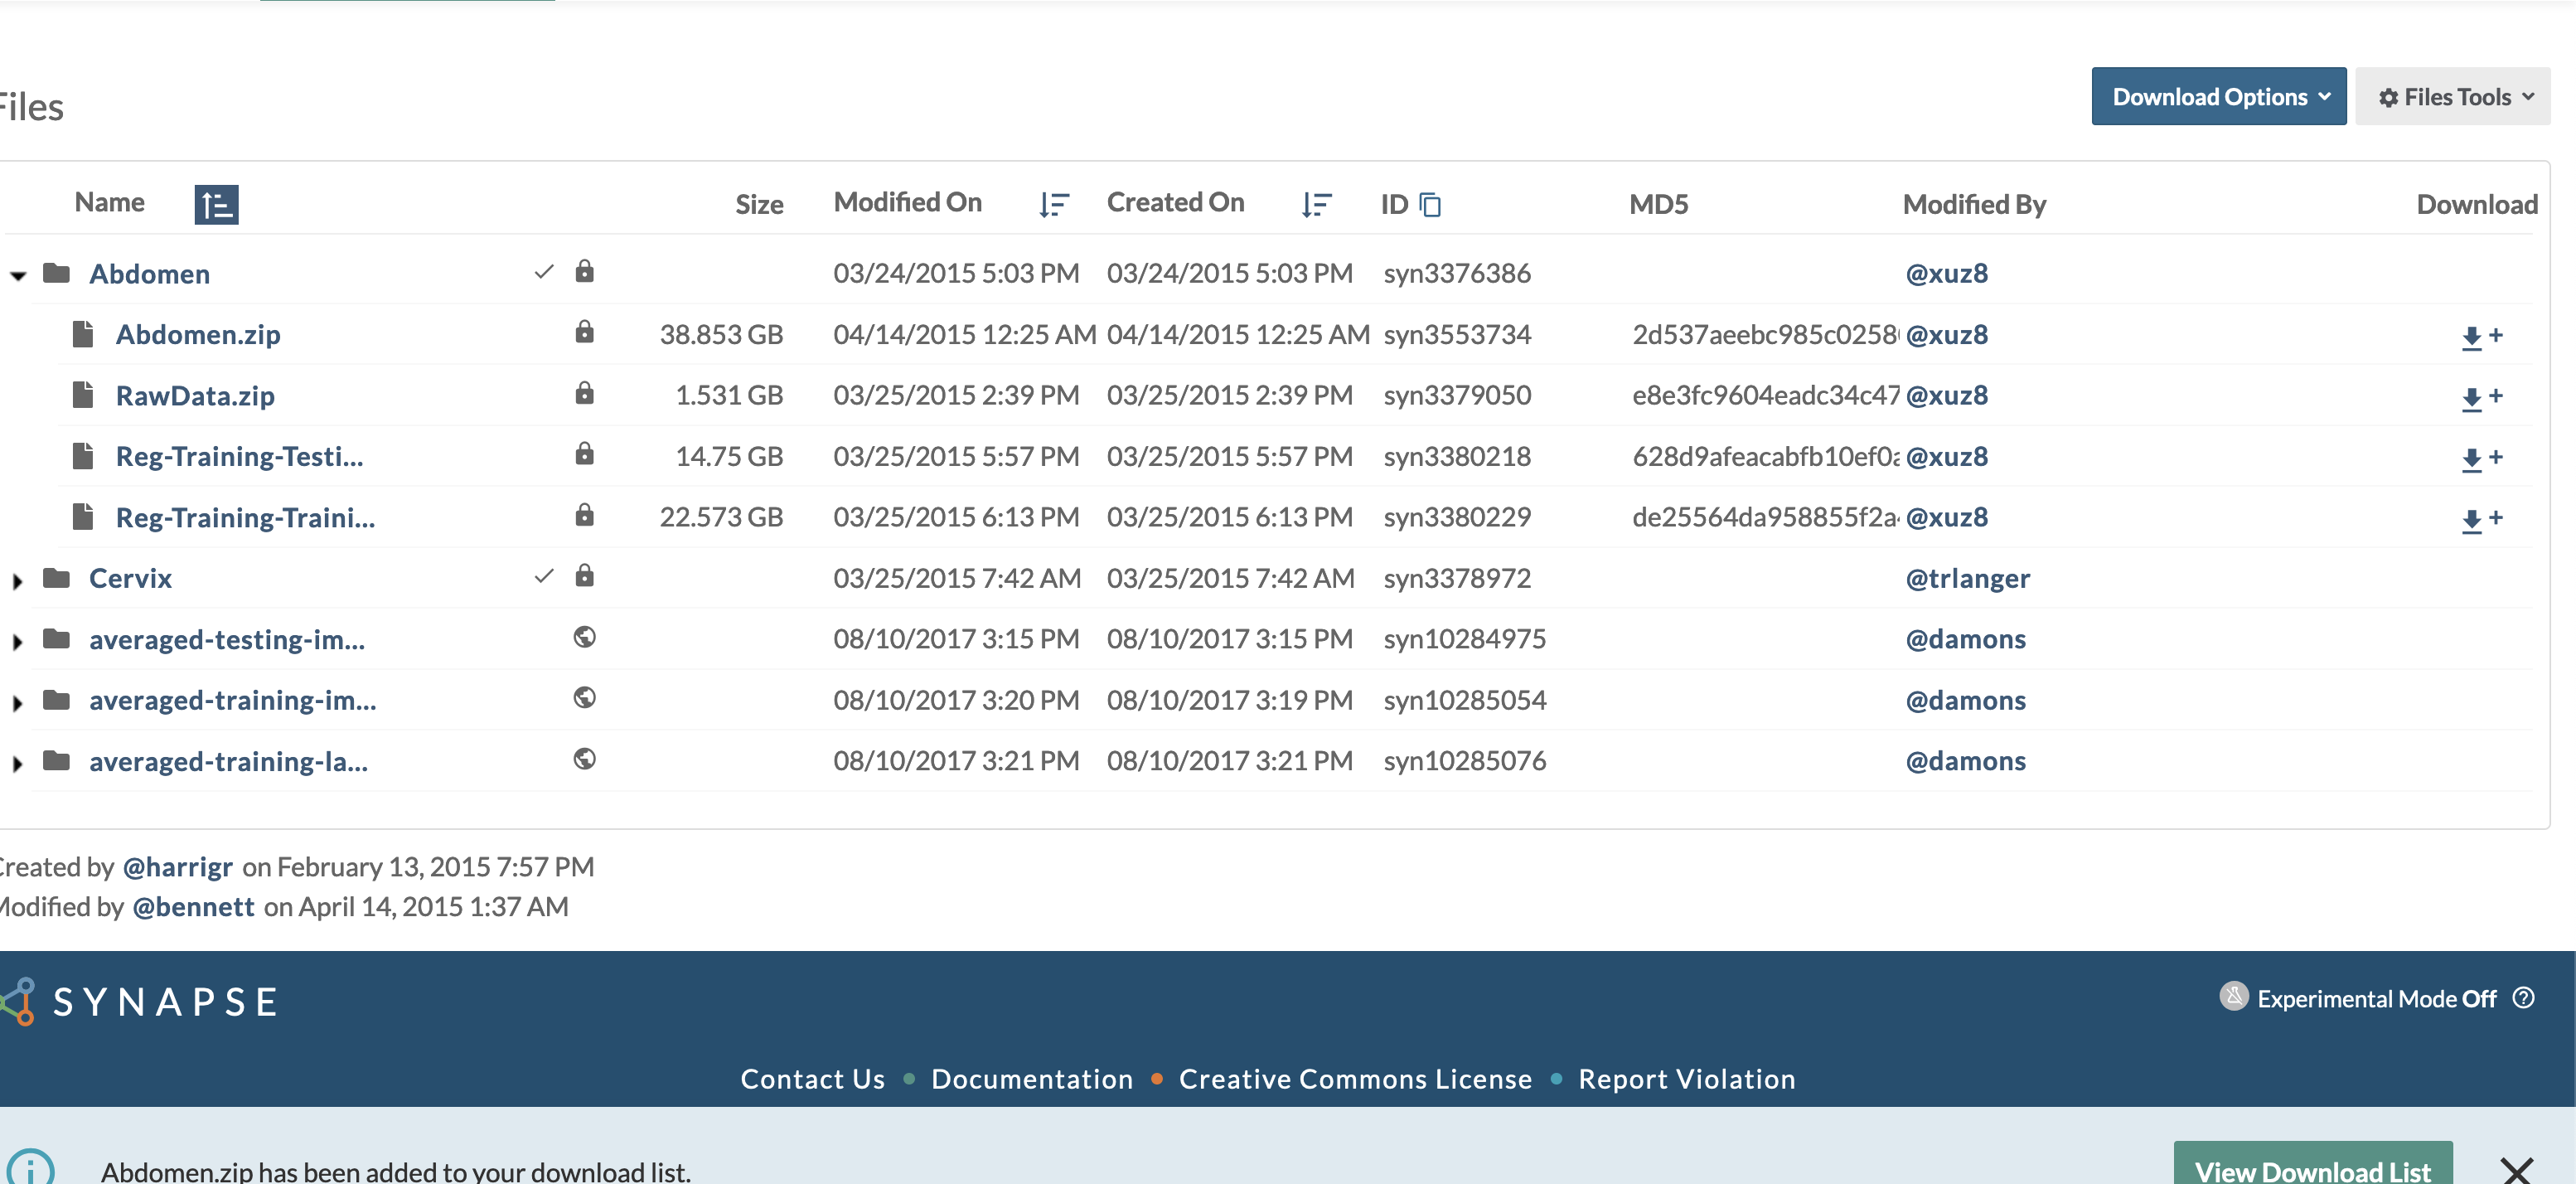


 ## Download dataset and format in the folder.
    1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json
    Example of JSON file:
     {
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        "imagesTs/img0061.nii.gz",
        "imagesTs/img0062.nii.gz",
        "imagesTs/img0063.nii.gz",
        "imagesTs/img0064.nii.gz",
        "imagesTs/img0065.nii.gz",
        "imagesTs/img0066.nii.gz",
        "imagesTs/img0067.nii.gz",
        "imagesTs/img0068.nii.gz",
        "imagesTs/img0069.nii.gz",
        "imagesTs/img0070.nii.gz",
        "imagesTs/img0071.nii.gz",
        "imagesTs/img0072.nii.gz",
        "imagesTs/img0073.nii.gz",
        "imagesTs/img0074.nii.gz",
        "imagesTs/img0075.nii.gz",
        "imagesTs/img0076.nii.gz",
        "imagesTs/img0077.nii.gz",
        "imagesTs/img0078.nii.gz",
        "imagesTs/img0079.nii.gz",
        "imagesTs/img0080.nii.gz"
    ],
    "training": [
        {
            "image": "imagesTr/img0001.nii.gz",
            "label": "labelsTr/label0001.nii.gz"
        },
        {
            "image": "imagesTr/img0002.nii.gz",
            "label": "labelsTr/label0002.nii.gz"
        },
        {
            "image": "imagesTr/img0003.nii.gz",
            "label": "labelsTr/label0003.nii.gz"
        },
        {
            "image": "imagesTr/img0004.nii.gz",
            "label": "labelsTr/label0004.nii.gz"
        },
        {
            "image": "imagesTr/img0005.nii.gz",
            "label": "labelsTr/label0005.nii.gz"
        },
        {
            "image": "imagesTr/img0006.nii.gz",
            "label": "labelsTr/label0006.nii.gz"
        },
        {
            "image": "imagesTr/img0007.nii.gz",
            "label": "labelsTr/label0007.nii.gz"
        },
        {
            "image": "imagesTr/img0008.nii.gz",
            "label": "labelsTr/label0008.nii.gz"
        },
        {
            "image": "imagesTr/img0009.nii.gz",
            "label": "labelsTr/label0009.nii.gz"
        },
        {
            "image": "imagesTr/img0010.nii.gz",
            "label": "labelsTr/label0010.nii.gz"
        },
        {
            "image": "imagesTr/img0021.nii.gz",
            "label": "labelsTr/label0021.nii.gz"
        },
        {
            "image": "imagesTr/img0022.nii.gz",
            "label": "labelsTr/label0022.nii.gz"
        },
        {
            "image": "imagesTr/img0023.nii.gz",
            "label": "labelsTr/label0023.nii.gz"
        },
        {
            "image": "imagesTr/img0024.nii.gz",
            "label": "labelsTr/label0024.nii.gz"
        },
        {
            "image": "imagesTr/img0025.nii.gz",
            "label": "labelsTr/label0025.nii.gz"
        },
        {
            "image": "imagesTr/img0026.nii.gz",
            "label": "labelsTr/label0026.nii.gz"
        },
        {
            "image": "imagesTr/img0027.nii.gz",
            "label": "labelsTr/label0027.nii.gz"
        },
        {
            "image": "imagesTr/img0028.nii.gz",
            "label": "labelsTr/label0028.nii.gz"
        },
        {
            "image": "imagesTr/img0029.nii.gz",
            "label": "labelsTr/label0029.nii.gz"
        },
        {
            "image": "imagesTr/img0030.nii.gz",
            "label": "labelsTr/label0030.nii.gz"
        },
        {
            "image": "imagesTr/img0031.nii.gz",
            "label": "labelsTr/label0031.nii.gz"
        },
        {
            "image": "imagesTr/img0032.nii.gz",
            "label": "labelsTr/label0032.nii.gz"
        },
        {
            "image": "imagesTr/img0033.nii.gz",
            "label": "labelsTr/label0033.nii.gz"
        },
        {
            "image": "imagesTr/img0034.nii.gz",
            "label": "labelsTr/label0034.nii.gz"
        }
    ],
    "validation": [
        {
            "image": "imagesTr/img0035.nii.gz",
            "label": "labelsTr/label0035.nii.gz"
        },
        {
            "image": "imagesTr/img0036.nii.gz",
            "label": "labelsTr/label0036.nii.gz"
        },
        {
            "image": "imagesTr/img0037.nii.gz",
            "label": "labelsTr/label0037.nii.gz"
        },
        {
            "image": "imagesTr/img0038.nii.gz",
            "label": "labelsTr/label0038.nii.gz"
        },
        {
            "image": "imagesTr/img0039.nii.gz",
            "label": "labelsTr/label0039.nii.gz"
        },
        {
            "image": "imagesTr/img0040.nii.gz",
            "label": "labelsTr/label0040.nii.gz"
        }
    ]
}
    

In [ ]:

data_dir = root_dir +'/'
split_JSON = "dataset_0.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 6/6 [00:23<00:00,  3.98s/it]


In [ ]:
val_files

[{'image': '/content/gcp-data/btcv/Abdomen/RawData/Colab/imagesTr/img0035.nii.gz',
  'label': '/content/gcp-data/btcv/Abdomen/RawData/Colab/labelsTr/label0035.nii.gz'},
 {'image': '/content/gcp-data/btcv/Abdomen/RawData/Colab/imagesTr/img0036.nii.gz',
  'label': '/content/gcp-data/btcv/Abdomen/RawData/Colab/labelsTr/label0036.nii.gz'},
 {'image': '/content/gcp-data/btcv/Abdomen/RawData/Colab/imagesTr/img0037.nii.gz',
  'label': '/content/gcp-data/btcv/Abdomen/RawData/Colab/labelsTr/label0037.nii.gz'},
 {'image': '/content/gcp-data/btcv/Abdomen/RawData/Colab/imagesTr/img0038.nii.gz',
  'label': '/content/gcp-data/btcv/Abdomen/RawData/Colab/labelsTr/label0038.nii.gz'},
 {'image': '/content/gcp-data/btcv/Abdomen/RawData/Colab/imagesTr/img0039.nii.gz',
  'label': '/content/gcp-data/btcv/Abdomen/RawData/Colab/labelsTr/label0039.nii.gz'},
 {'image': '/content/gcp-data/btcv/Abdomen/RawData/Colab/imagesTr/img0040.nii.gz',
  'label': '/content/gcp-data/btcv/Abdomen/RawData/Colab/labelsTr/label0

## Check data shape and visualize

image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


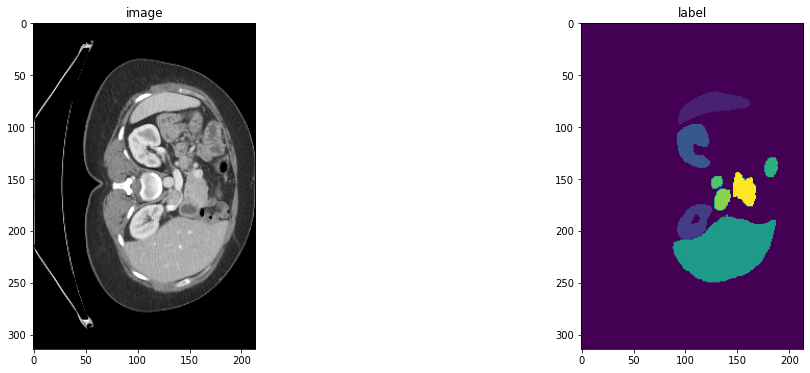

In [ ]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = UNETR(
#     in_channels=1,
#     out_channels=14,
#     img_size=(96, 96, 96),
#     feature_size=16,
#     hidden_size=768,
#     mlp_dim=3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.0,
# ).to(device)

model = BasicUNet(
    in_channels=1,
    out_channels=14,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

BasicUNet features: (32, 32, 64, 128, 256, 32).


### Execute a typical PyTorch training process

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        model_name_epoch = model_name + str(global_step) + ".pth" 
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, model_name_epoch)
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model_name_epoch = model_name + str(global_step_best) + ".pth" 
print(model_name_epoch)
model.load_state_dict(torch.load(os.path.join(root_dir, model_name_epoch)))

Training (500 / 25000 Steps) (loss=2.04392):  88%|████████▊ | 21/24 [01:36<00:58, 19.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.15990597009658813 Current Avg. Dice: 0.15990597009658813


Training (1000 / 25000 Steps) (loss=1.61899):  71%|███████   | 17/24 [01:28<02:13, 19.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2251894474029541 Current Avg. Dice: 0.2251894474029541


Training (1500 / 25000 Steps) (loss=1.32265):  54%|█████▍    | 13/24 [01:21<03:28, 18.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.24502132833003998 Current Avg. Dice: 0.24502132833003998


Training (2000 / 25000 Steps) (loss=1.19805):  38%|███▊      | 9/24 [01:14<04:58, 19.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3551962375640869 Current Avg. Dice: 0.3551962375640869


Training (2500 / 25000 Steps) (loss=1.01215):  21%|██        | 5/24 [01:09<07:20, 23.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.46691954135894775 Current Avg. Dice: 0.46691954135894775


Training (3000 / 25000 Steps) (loss=1.03498):   4%|▍         | 1/24 [01:00<23:12, 60.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.48352906107902527 Current Avg. Dice: 0.48352906107902527


Training (3500 / 25000 Steps) (loss=0.93928):  88%|████████▊ | 21/24 [01:35<00:57, 19.10s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5067850947380066 Current Avg. Dice: 0.5067850947380066


Training (4000 / 25000 Steps) (loss=1.14745):  71%|███████   | 17/24 [01:28<02:13, 19.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6104121804237366 Current Avg. Dice: 0.6104121804237366


Training (4500 / 25000 Steps) (loss=0.91710):  54%|█████▍    | 13/24 [01:21<03:29, 19.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.611935019493103 Current Avg. Dice: 0.611935019493103


Training (5000 / 25000 Steps) (loss=0.85034):  38%|███▊      | 9/24 [01:14<04:54, 19.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6499438881874084 Current Avg. Dice: 0.6499438881874084


Training (5500 / 25000 Steps) (loss=0.81072):  21%|██        | 5/24 [00:47<04:52, 15.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6499438881874084 Current Avg. Dice: 0.6475870609283447


Training (6000 / 25000 Steps) (loss=0.83593):   4%|▍         | 1/24 [01:02<24:08, 62.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6655029654502869 Current Avg. Dice: 0.6655029654502869


Training (6500 / 25000 Steps) (loss=0.72030):  88%|████████▊ | 21/24 [01:15<00:38, 13.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6655029654502869 Current Avg. Dice: 0.6583700180053711


Training (7000 / 25000 Steps) (loss=0.83795):  71%|███████   | 17/24 [01:29<02:15, 19.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6721121668815613 Current Avg. Dice: 0.6721121668815613


Training (7500 / 25000 Steps) (loss=0.98875):  54%|█████▍    | 13/24 [01:20<03:27, 18.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6764242053031921 Current Avg. Dice: 0.6764242053031921


Training (8000 / 25000 Steps) (loss=0.80080):  38%|███▊      | 9/24 [01:17<05:06, 20.46s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7009971737861633 Current Avg. Dice: 0.7009971737861633


Training (8500 / 25000 Steps) (loss=0.50530):  21%|██        | 5/24 [01:05<06:54, 21.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7357656955718994 Current Avg. Dice: 0.7357656955718994


Training (9000 / 25000 Steps) (loss=0.87430):   4%|▍         | 1/24 [01:00<23:06, 60.30s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7923834919929504 Current Avg. Dice: 0.7923834919929504


Training (9500 / 25000 Steps) (loss=0.50475):  88%|████████▊ | 21/24 [01:35<00:57, 19.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7998535633087158 Current Avg. Dice: 0.7998535633087158


Training (10000 / 25000 Steps) (loss=0.94460):  71%|███████   | 17/24 [01:26<02:09, 18.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8091855645179749 Current Avg. Dice: 0.8091855645179749


Training (10500 / 25000 Steps) (loss=0.75363):  54%|█████▍    | 13/24 [01:18<03:21, 18.33s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8158340454101562 Current Avg. Dice: 0.8158340454101562


Training (11000 / 25000 Steps) (loss=0.71470):  38%|███▊      | 9/24 [00:55<03:23, 13.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8158340454101562 Current Avg. Dice: 0.8093094825744629


Training (11500 / 25000 Steps) (loss=0.83993):  21%|██        | 5/24 [00:47<04:53, 15.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8158340454101562 Current Avg. Dice: 0.8039705157279968


Training (12000 / 25000 Steps) (loss=0.78580):   4%|▍         | 1/24 [00:40<15:36, 40.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8158340454101562 Current Avg. Dice: 0.7894017696380615


Training (12500 / 25000 Steps) (loss=0.77257):  88%|████████▊ | 21/24 [01:15<00:39, 13.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8158340454101562 Current Avg. Dice: 0.8055642247200012


Training (13000 / 25000 Steps) (loss=0.61561):  71%|███████   | 17/24 [01:09<01:31, 13.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8158340454101562 Current Avg. Dice: 0.8050799369812012


Training (13500 / 25000 Steps) (loss=0.84428):  54%|█████▍    | 13/24 [01:01<02:24, 13.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8158340454101562 Current Avg. Dice: 0.8105691075325012


Training (14000 / 25000 Steps) (loss=0.56748):  38%|███▊      | 9/24 [01:14<04:52, 19.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8246471881866455 Current Avg. Dice: 0.8246471881866455


Training (14500 / 25000 Steps) (loss=0.60189):  21%|██        | 5/24 [01:07<07:05, 22.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.830686092376709 Current Avg. Dice: 0.830686092376709


Training (15000 / 25000 Steps) (loss=0.81735):   4%|▍         | 1/24 [00:40<15:39, 40.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.830686092376709 Current Avg. Dice: 0.8246847987174988


Training (15500 / 25000 Steps) (loss=0.41882):  88%|████████▊ | 21/24 [01:15<00:38, 12.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.830686092376709 Current Avg. Dice: 0.8279356360435486


Training (16000 / 25000 Steps) (loss=0.60226):  71%|███████   | 17/24 [01:08<01:31, 13.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.830686092376709 Current Avg. Dice: 0.8179847598075867


Training (16500 / 25000 Steps) (loss=0.68867):  54%|█████▍    | 13/24 [01:01<02:24, 13.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.830686092376709 Current Avg. Dice: 0.8127118945121765


Training (17000 / 25000 Steps) (loss=0.66618):  38%|███▊      | 9/24 [00:54<03:23, 13.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.830686092376709 Current Avg. Dice: 0.8305080533027649


Training (17500 / 25000 Steps) (loss=0.73394):  21%|██        | 5/24 [01:07<07:08, 22.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8308124542236328 Current Avg. Dice: 0.8308124542236328


Training (18000 / 25000 Steps) (loss=0.62334):   4%|▍         | 1/24 [01:00<23:12, 60.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8329887986183167 Current Avg. Dice: 0.8329887986183167


Training (18500 / 25000 Steps) (loss=0.85604):  88%|████████▊ | 21/24 [01:15<00:38, 12.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8329887986183167 Current Avg. Dice: 0.7674909234046936


Training (19000 / 25000 Steps) (loss=0.42147):  71%|███████   | 17/24 [01:08<01:31, 13.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8329887986183167 Current Avg. Dice: 0.8320702910423279


Training (19500 / 25000 Steps) (loss=0.57930):  54%|█████▍    | 13/24 [01:01<02:24, 13.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8329887986183167 Current Avg. Dice: 0.8312995433807373


Training (20000 / 25000 Steps) (loss=0.51258):  38%|███▊      | 9/24 [01:13<04:49, 19.28s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8359243869781494 Current Avg. Dice: 0.8359243869781494


Training (20500 / 25000 Steps) (loss=0.72960):  21%|██        | 5/24 [00:47<04:52, 15.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8359243869781494 Current Avg. Dice: 0.8296273350715637


Training (21000 / 25000 Steps) (loss=0.49686):   4%|▍         | 1/24 [00:40<15:29, 40.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8359243869781494 Current Avg. Dice: 0.8334658741950989


Training (21500 / 25000 Steps) (loss=0.41175):  88%|████████▊ | 21/24 [01:33<00:55, 18.65s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8419627547264099 Current Avg. Dice: 0.8419627547264099


Training (22000 / 25000 Steps) (loss=0.58932):  71%|███████   | 17/24 [01:08<01:31, 13.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419627547264099 Current Avg. Dice: 0.8411495089530945


Training (22500 / 25000 Steps) (loss=0.75934):  54%|█████▍    | 13/24 [01:01<02:24, 13.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419627547264099 Current Avg. Dice: 0.7786624431610107


Training (23000 / 25000 Steps) (loss=0.71079):  38%|███▊      | 9/24 [00:54<03:23, 13.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419627547264099 Current Avg. Dice: 0.8369483947753906


Training (23500 / 25000 Steps) (loss=0.57306):  21%|██        | 5/24 [00:47<04:53, 15.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419627547264099 Current Avg. Dice: 0.815606415271759


Training (24000 / 25000 Steps) (loss=0.69601):   4%|▍         | 1/24 [00:40<15:29, 40.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419627547264099 Current Avg. Dice: 0.8113469481468201


Training (24500 / 25000 Steps) (loss=0.52612):  88%|████████▊ | 21/24 [01:35<00:57, 19.02s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8422436118125916 Current Avg. Dice: 0.8422436118125916


Training (25000 / 25000 Steps) (loss=0.43391):  71%|███████   | 17/24 [01:08<01:31, 13.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8422436118125916 Current Avg. Dice: 0.8391990661621094


Training (25007 / 25000 Steps) (loss=0.52372): 100%|██████████| 24/24 [01:20<00:00,  3.36s/it]


NameError: ignored

In [ ]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

### Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

In [ ]:
case_num = 4
model_name_epoch = model_name + str(global_step_best) + ".pth" 
model.load_state_dict(torch.load(os.path.join(root_dir, model_name_epoch)))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)